# Topics

In [1]:
import pandas as pd
from stop_words import get_stop_words
import string
import unicodedata
from num2words import num2words

import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt

Cargamos los datos obtenidos en el primer punto de la práctica.

In [2]:
df = pd.read_csv('./scraping/data/news.csv', encoding='latin-1')
df.head()

,scraping_date,url,headline,text,lang
0,2020-08-30,https://www.20minutos.es/noticia/4364400/0/rec...,RÃ©cord de contagios por coronavirus en varias...,Los contagios por coronavirus siguen aumenta...,es
1,2020-08-30,https://www.20minutos.es/noticia/4364548/0/que...,Â¿QuÃ© pasa este curso con las extraescolares?,La incertidumbre que reina este curso por la ...,es
2,2020-08-30,https://www.20minutos.es/deportes/noticia/4364...,Nuevo giro en el 'caso Messi: la clÃ¡usula ya ...,Las idas y venidas que estÃ¡ causando la sali...,es
3,2020-08-30,https://www.20minutos.es/noticia/4363903/0/ens...,AsÃ­ es el ensayo en fase 2 de la vacuna del c...,EspaÃ±a es uno de los paÃ­ses donde se realiza...,es
4,2020-08-30,https://www.20minutos.es/noticia/4364515/0/gob...,El Gobierno mira a diciembre para poder empeza...,Si tuviera que hacer un pronÃ³stico hoy con lo...,es


In [3]:
df.dropna(inplace=True)

In [4]:
df.isnull().any()

scraping_date    False
url              False
headline         False
text             False
lang             False
dtype: bool

Vamos a iniciar con la extracción de topics en español cogiendo las noticias.

In [5]:
df_es = df.drop(df[df.lang != 'es'].index)
df_es = df_es['text']
df_es.head()

0    Los contagios por  coronavirus  siguen aumenta...
1    La incertidumbre que reina este curso por la  ...
2    Las idas y venidas que estÃ¡ causando la  sali...
3    EspaÃ±a es uno de los paÃ­ses donde se realiza...
4    Si tuviera que hacer un pronÃ³stico hoy con lo...
Name: text, dtype: object

Vamos a realizar el preprocesado del texto.

In [6]:
# Obtenemos un diccionario de lemas
lemmas_dict = {}
with open('./lemmatization_lists/lemmatization-es.txt', 'r', encoding='utf-8') as f:
    for line in f:
        (key, val) = line.split()
        lemmas_dict[str(val)] = key

In [7]:
# Obtenemos una lista de stopwords
sw_list = get_stop_words('es')

In [8]:
# Tabla para eliminar signos de puntuación
table = str.maketrans('', '', string.punctuation)
# Procesamos los textos
processed_texts = []
for text in df_es:
    processed_text = []
    # Convertimos el texto a minúsuculas
    text = text.lower()
    # Eliminamos caracteres extraños, elimina ñ y tildes 
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # Segmentamos el texto en frases
    sentences = text.split('.')
    # Para cada frase
    prev_word = ""
    prev_word_2 = ""
    for sentence in sentences:
        words = sentence.split(' ')
        # Para cada palabra
        for word in words:
            # Eliminamos stopwords y signos de puntuación
            if word not in string.punctuation and word not in sw_list: 
                word = word.translate(table)
                # lematizamos
                word = lemmas_dict.get(word, word)
                # Pasamos lo números a palabras
                if word.isdigit():
                    word = num2words(word, lang='es')
                # Eliminamos palabras menores de 3 letras
                if len(word) > 3:
                    # processed_text.append(word)
                    if prev_word:
                        processed_text.append(prev_word + " " + word)
                        if prev_word_2:
                            processed_text.append(prev_word_2 + " " + prev_word + " " + word)
                    prev_word_2 = prev_word
                    prev_word = word
    processed_texts.append(processed_text)

In [9]:
len(processed_texts)

1732

In [11]:
print(processed_texts[4])

['hacer prona3stico', 'prona3stico dato', 'hacer prona3stico dato', 'dato disponer', 'prona3stico dato disponer', 'disponer diraa', 'dato disponer diraa', 'diraa diciembre', 'disponer diraa diciembre', 'diciembre podraamos', 'diraa diciembre podraamos', 'podraamos empezar', 'diciembre podraamos empezar', 'empezar vacunar', 'podraamos empezar vacunar', 'vacunar colectivo', 'empezar vacunar colectivo', 'colectivo necesitar', 'vacunar colectivo necesitar', 'necesitar palabra', 'colectivo necesitar palabra', 'palabra dela', 'necesitar palabra dela', 'dela ministro', 'palabra dela ministro', 'ministro sanidad', 'dela ministro sanidad', 'sanidad salvador', 'ministro sanidad salvador', 'salvador illa', 'sanidad salvador illa', 'illa semana', 'salvador illa semana', 'semana quedar', 'illa semana quedar', 'quedar marcar', 'semana quedar marcar', 'marcar anunciar', 'quedar marcar anunciar', 'anunciar espaaa', 'marcar anunciar espaaa', 'espaaa empezar', 'anunciar espaaa empezar', 'empezar fase', 

## Entrenamos el modelo LDA

Creamos el diccionario y la matriz documento-término.

In [12]:
dictionary = Dictionary(processed_texts)

In [13]:
type(dictionary)

gensim.corpora.dictionary.Dictionary

In [14]:
# Comprobamos el tamaño de nuestro diccionario
len(dictionary)

815137

In [16]:
corpus = [dictionary.doc2bow(doc) for doc in processed_texts]
print(corpus[21])

[(661, 2), (3138, 1), (5497, 1), (9380, 1), (9381, 1), (9382, 1), (9383, 1), (9384, 1), (9385, 1), (9386, 1), (9387, 1), (9388, 2), (9389, 1), (9390, 1), (9391, 1), (9392, 1), (9393, 1), (9394, 1), (9395, 1), (9396, 1), (9397, 1), (9398, 1), (9399, 1), (9400, 1), (9401, 1), (9402, 1), (9403, 1), (9404, 1), (9405, 1), (9406, 1), (9407, 1), (9408, 1), (9409, 1), (9410, 1), (9411, 1), (9412, 1), (9413, 1), (9414, 1), (9415, 1), (9416, 1), (9417, 1), (9418, 1), (9419, 1), (9420, 1), (9421, 1), (9422, 1), (9423, 1), (9424, 1), (9425, 1), (9426, 1), (9427, 2), (9428, 1), (9429, 1), (9430, 1), (9431, 1), (9432, 1), (9433, 1), (9434, 1), (9435, 1), (9436, 1), (9437, 1), (9438, 1), (9439, 1), (9440, 1), (9441, 1), (9442, 1), (9443, 1), (9444, 1), (9445, 1), (9446, 1), (9447, 1), (9448, 1), (9449, 1), (9450, 1), (9451, 1), (9452, 1), (9453, 1), (9454, 1), (9455, 1), (9456, 1), (9457, 1), (9458, 1), (9459, 1), (9460, 1), (9461, 1), (9462, 1), (9463, 1), (9464, 1), (9465, 1), (9466, 1), (9467, 1),

Entrenamos al modelo LDA, y en una primera aproximación cogemos 10 topics.

In [18]:
num_topics = 10

lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    iterations=5,
    passes=10,
    alpha='auto'
)

Ahora vemos los topics que nos propone:

In [19]:
lda_model.show_topics()

[(0,
  '0.000*"favor marcar" + 0.000*"facilitar fecho nacimiento" + 0.000*"conocerte poder ofrecerte" + 0.000*"vario temer" + 0.000*"marcar vario temer" + 0.000*"favor marcar vario" + 0.000*"querer conocerte poder" + 0.000*"fecho nacimiento" + 0.000*"facilitar fecho" + 0.000*"breve preguntar"'),
 (1,
  '0.000*"siete daas" + 0.000*"aoltimos siete daas" + 0.000*"aoltimos siete" + 0.000*"poder facilitar" + 0.000*"poder facilitar fecho" + 0.000*"adelantar favor" + 0.000*"marcar vario" + 0.000*"poder ofrecerte" + 0.000*"conocerte poder" + 0.000*"respondernos breve"'),
 (2,
  '0.000*"comunidad madrid" + 0.000*"poder facilitar" + 0.000*"favor marcar" + 0.000*"respondernos breve preguntar" + 0.000*"fecho nacimiento" + 0.000*"adelantar favor" + 0.000*"querer conocerte" + 0.000*"favor marcar vario" + 0.000*"facilitar fecho" + 0.000*"querer conocerte poder"'),
 (3,
  '0.000*"martan villa" + 0.000*"guardia civil" + 0.000*"comunidad madrid" + 0.000*"querer conocerte poder" + 0.000*"facilitar fecho"

In [20]:
word_dict = {};
for i in range(num_topics):
    words = lda_model.show_topic(i, topn = 20)
    word_dict['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict)

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05,Topic #06,Topic #07,Topic #08,Topic #09,Topic #10
0,favor marcar,siete daas,comunidad madrid,martan villa,millón euro,comunidad madrid,materia oscuro,redar social,millón euro,ofrecerte contenido
1,facilitar fecho nacimiento,aoltimos siete daas,poder facilitar,guardia civil,cero millón,conocerte poder ofrecerte,millón euro,publicacia3n compartir,cero millón,respondernos breve preguntar
2,conocerte poder ofrecerte,aoltimos siete,favor marcar,comunidad madrid,favor marcar vario,ofrecerte contenido,favor marcar vario,agujero negro,vario temer,breve preguntar
3,vario temer,poder facilitar,respondernos breve preguntar,querer conocerte poder,fecho nacimiento,respondernos breve,poder ofrecerte,llevar cabo,llevar cabo,facilitar fecho nacimiento
4,marcar vario temer,poder facilitar fecho,fecho nacimiento,facilitar fecho,respondernos breve preguntar,marcar vario,poder facilitar,policaa nacional,florentino parez,poder ofrecerte contenido
5,favor marcar vario,adelantar favor,adelantar favor,respondernos breve preguntar,poder ofrecerte,facilitar fecho,fecho nacimiento,cero euro,poder ofrecerte,querer conocerte
6,querer conocerte poder,marcar vario,querer conocerte,ofrecerte contenido,favor marcar,respondernos breve preguntar,facilitar fecho,comunidad madrid,facilitar fecho,marcar vario temer
7,fecho nacimiento,poder ofrecerte,favor marcar vario,poder ofrecerte contenido,vario temer,conocerte poder,poder facilitar fecho,castilla lea3n,querer conocerte,conocerte poder
8,facilitar fecho,conocerte poder,facilitar fecho,poder facilitar,querer conocerte,poder facilitar,respondernos breve,veinticuatro hora,facilitar fecho nacimiento,fecho nacimiento
9,breve preguntar,respondernos breve,querer conocerte poder,marcar vario temer,poder facilitar fecho,vario temer,querer conocerte,centro educativo,breve preguntar,querer conocerte poder


In [ ]:
# Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # Medida de qué tan bueno es el modelo. Cuanto más bajo, mejor

# Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.669118913200004

Coherence Score:  0.32918668570312865


Los resultados no son los esperados. Apenas salen temas de actualidad como cabe esperar. Observamos que se repiten mucho palabras como: poder ofrecerte contenido, querer conocerte poder, respodernos breve, facilitar fecho nacimiento...

Esto se debe a que hay periódicos que incluyen unos párrafos finales donde nos piden responder un breve cuestionario para que nos puedan conocer mejor y ofrecernos contenidos que nos interesen.

Ejemplo en todas las noticias de ABC:
" ï¿½Hola ! Queremos conocerte para poder ofrecerte los contenidos segï¿½n tus preferencias ï¿½Podrï¿½as respondernos unas breves preguntas? No te llevarï¿½ mï¿½s de un minuto.ï¿½Gracias por adelantado! Por favor ï¿½Nos puedes facilitar tu fecha de nacimiento y gï¿½nero? Por favor marca uno o varios temas que sean de tu interï¿½s."

In [21]:
print(processed_texts[676])

['mitad provincia', 'provincia espai12a', 'mitad provincia espai12a', 'espai12a esti12n', 'provincia espai12a esti12n', 'esti12n peligrar', 'espai12a esti12n peligrar', 'peligrar alto', 'esti12n peligrar alto', 'alto descontrol', 'peligrar alto descontrol', 'descontrol pandemia', 'alto descontrol pandemia', 'pandemia coronavirus', 'descontrol pandemia coronavirus', 'coronavirus mapa', 'pandemia coronavirus mapa', 'mapa riesgo', 'coronavirus mapa riesgo', 'riesgo realizar', 'mapa riesgo realizar', 'realizar partir', 'riesgo realizar partir', 'partir estudiar', 'realizar partir estudiar', 'estudiar investigador', 'partir estudiar investigador', 'investigador biocomsc', 'estudiar investigador biocomsc', 'biocomsc mostrar', 'investigador biocomsc mostrar', 'mostrar situacii12n', 'biocomsc mostrar situacii12n', 'situacii12n segi12n', 'mostrar situacii12n segi12n', 'segi12n ni12mero', 'situacii12n segi12n ni12mero', 'ni12mero contagio', 'segi12n ni12mero contagio', 'contagio velocidad', 'ni1

Esto nos hace replantearnos la situación:
- se puede eliminar parte del texto de la noticia para quitarnos esos fragmentos. Pero corremos riesgo de quitar de más o de menos y por tanto perder información de la noticia. O que el periódico cambie la estructura, etc...
- podemos quitar de nuestro dataset este periódico (ABC) que nos ensucia la extracción de topics.
- **podemos quedarnos simplemente con los titulares.**

Optamos por la tercera opción ya que creemos que de esta forma vamos a reducir el tamaño del diccionario y las palabras con las que vamos a trabajar se van a ajustar más a la realidad. Sabemos que en los titulares vienen las palabras claves sobre lo que trata la noticia.

Repetimos el proceso anterior, pero ahora cargamos los titulares en vez del cuerpo de la noticia:

In [22]:
df = pd.read_csv('./scraping/data/news.csv', encoding='latin-1')
df.dropna(inplace=True)
df_es = df.drop(df[df.lang != 'es'].index)
df_es = df_es['headline']
df_es.head()

0    RÃ©cord de contagios por coronavirus en varias...
1       Â¿QuÃ© pasa este curso con las extraescolares?
2    Nuevo giro en el 'caso Messi: la clÃ¡usula ya ...
3    AsÃ­ es el ensayo en fase 2 de la vacuna del c...
4    El Gobierno mira a diciembre para poder empeza...
Name: headline, dtype: object

In [25]:
# Tabla para eliminar signos de puntuación
table = str.maketrans('', '', string.punctuation)
# Procesamos los textos
processed_texts = []
for text in df_es:
    processed_text = []
    # Convertimos el texto a minúsuculas
    text = text.lower()
    # Eliminamos caracteres extraños, elimina ñ y tildes 
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # Segmentamos el texto en frases
    sentences = text.split('.')
    # Para cada frase
    prev_word = ""
    prev_word_2 = ""
    for sentence in sentences:
        words = sentence.split(' ')
        # Para cada palabra
        for word in words:
            # Eliminamos stopwords y signos de puntuación
            if word not in string.punctuation and word not in sw_list: 
                word = word.translate(table)
                # lematizamos
                word = lemmas_dict.get(word, word)
                # Pasamos lo números a palabras
                if word.isdigit():
                    word = num2words(word, lang='es')
                # Eliminamos palabras menores de 3 letras
                if len(word) > 3:
                    # processed_text.append(word)
                    if prev_word:
                        processed_text.append(prev_word + " " + word)
                        if prev_word_2:
                            processed_text.append(prev_word_2 + " " + prev_word + " " + word)
                    prev_word_2 = prev_word
                    prev_word = word
    processed_texts.append(processed_text)

In [26]:
dictionary = Dictionary(processed_texts)
corpus = [dictionary.doc2bow(doc) for doc in processed_texts]
len(dictionary)

19093

Lo primero que llama la atención es que hemos reducido nuestro diccionario de más de 800.000 palabras a menos de 20.000

In [27]:
num_topics = 10

lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    iterations=5,
    passes=10,
    alpha='auto'
)

lda_model.show_topics()

[(0,
  '0.001*"veinticuatro hora" + 0.001*"caso coronavirus" + 0.001*"marti12n villa" + 0.001*"mesar dialogar" + 0.001*"fase delicado" + 0.001*"negociar presupuesto" + 0.001*"encontrar fase delicado" + 0.001*"ingresar coronavirus encontrar" + 0.001*"ingresar coronavirus" + 0.001*"coronavirus encontrar fase"'),
 (1,
  '0.001*"volver cole" + 0.001*"escalonar calendario volver" + 0.001*"calendario volver" + 0.001*"calendario volver cole" + 0.001*"retrasar escalonar" + 0.001*"empezar retrasar escalonar" + 0.001*"escalonar calendario" + 0.001*"conferenciar presidente" + 0.001*"atresplayer premium" + 0.001*"retrasar escalonar calendario"'),
 (2,
  '0.001*"volver cole" + 0.001*"guardia civil" + 0.001*"tres guardia civil" + 0.001*"tres guardia" + 0.001*"carla suarez" + 0.001*"linfoma hodgkin" + 0.001*"suarez anunciar" + 0.001*"carla suarez anunciar" + 0.001*"cerrar marula local" + 0.001*"cerrar marula"'),
 (3,
  '0.001*"cero millón" + 0.001*"vacuno covid19" + 0.001*"recibir vacuno" + 0.001*"re

In [28]:
word_dict = {};
for i in range(num_topics):
    words = lda_model.show_topic(i, topn = 20)
    word_dict['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict)

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05,Topic #06,Topic #07,Topic #08,Topic #09,Topic #10
0,veinticuatro hora,volver cole,volver cole,cero millón,septiembre dos mil veinte,positivo coronavirus,veinticuatro hora,morir celda,llevar hijo colegiar,veinticuatro hora
1,caso coronavirus,escalonar calendario volver,guardia civil,vacuno covid19,volver cole,berlusconi positivo coronavirus,ocho quinientos ochenta y uno,igor gonzalez,llevar hijo,aoltimas veinticuatro
2,marti12n villa,calendario volver,tres guardia civil,recibir vacuno,viernes cuatro septiembre,berlusconi positivo,caixabank bankia,llevar hijo,hijo colegiar,aoltimas veinticuatro hora
3,mesar dialogar,calendario volver cole,tres guardia,recibir vacuno covid19,viernes cuatro,alberto soro,tres seiscientos sesenta y tres i12ltimas,pazo meiras,cero euro,caso covid19
4,fase delicado,retrasar escalonar,carla suarez,nuevo normalidad,iglesia contradecir,volver espai12a,i12ltimas veinticuatro,covid educacii12n,casar dina,comunitat valenciano
5,negociar presupuesto,empezar retrasar escalonar,linfoma hodgkin,comunidad madrid,cuatro septiembre,roberto leal,seiscientos sesenta y tres i12ltimas,fondo covid,nuevo restricción,agresia3n sexual
6,encontrar fase delicado,escalonar calendario,suarez anunciar,mesar dialogar,cuatro septiembre dos mil veinte,caser lorca,seiscientos sesenta y tres i12ltimas veinticuatro,fondo covid educacii12n,milla3n billete,contagiar coronavirus
7,ingresar coronavirus encontrar,conferenciar presidente,carla suarez anunciar,aquian deberaa,comprobar resultar,silvio berlusconi,i12ltimas veinticuatro hora,conceder tres,veintinueve setecientos ochenta personar,espaaa directo
8,ingresar coronavirus,atresplayer premium,cerrar marula local,aquian deberaa recibir,resultar sortear,derecho bajo,tres seiscientos sesenta y tres,preso igor gonzalez,iglesia insistir,coronavirus espaaa directo
9,coronavirus encontrar fase,retrasar escalonar calendario,cerrar marula,vacuno covid19 haber,comprobar resultar sortear,millón euro,notificar ocho,conceder tres gradar,hermann tertsch,nuevo caso


In [29]:
# Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # Medida de qué tan bueno es el modelo. Cuanto más bajo, mejor

# Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -10.56068694562954

Coherence Score:  0.5212952273757642


A la vista de los resultados vemos que la cosa va mejorando. Por un lado los datos numéricos nos avalan. La perplexity va bajando y el coherence score subiendo.

Además vemos que los topics que nos ofrece van teniendo más sentido y sí nos representan temas de actualidad: coronavirus, mesar dialogar, volver cole, caixabank bankia

No obstante, seguimos teniendo margen de mejora. Por un lado vemos que no hay diferenciación clara entre los topics y además el lenguaje que utiliza se ve que está influenciado por el proceso de lematización. Esto puede ser un problema si luego lo queremos cruzar con Twiter, ya que el lenguaje que usa la gente no es exactamente así. Ejemplos como "vacuno covid19" o "volver cole" se explican por sí solos.

**De cara a avanzar en estos dos aspectos vamos a comparar distintos modelos en base al número de topics propuestos y vamos a quitar la lematización.**

In [30]:
#Función que compara distintos modelos(número de topics a usar) en base a sus valores de coherencia
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        
        # Build LDA model
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=dictionary,
                                                num_topics=num_topics)
        
        # Create a list of LDA models
        model_list.append(model)
        
        # Compute the Coherence for each model
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

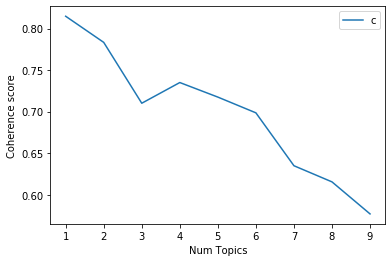

In [31]:
start_ = 1
end_ = 10
step_ = 1

model_list, coherence_values = compute_coherence_values(
    dictionary=dictionary,
    corpus=corpus,
    texts=processed_texts,
    start=start_,
    limit=end_,
    step=step_
)

x = range(start_, end_, step_)
plt.plot(x, coherence_values)
plt.xlabel('Num Topics')
plt.ylabel('Coherence score')
plt.legend(('coherence_values'), loc='best')
plt.show()

Vemos que el mejor Coherence Score lo obtenemos para un solo topic, así que vamos a trabajar así y nos quedaremos con las palabras claves de ese único topic como nuestros temas importantes del día.

Por tanto, repetimos el proceso para un solo topic y además quitamos la lematización.

In [32]:
df = pd.read_csv('./scraping/data/news.csv', encoding='latin-1')
df.dropna(inplace=True)
df_es = df.drop(df[df.lang != 'es'].index)
df_es = df_es['headline']
df_es.head()

0    RÃ©cord de contagios por coronavirus en varias...
1       Â¿QuÃ© pasa este curso con las extraescolares?
2    Nuevo giro en el 'caso Messi: la clÃ¡usula ya ...
3    AsÃ­ es el ensayo en fase 2 de la vacuna del c...
4    El Gobierno mira a diciembre para poder empeza...
Name: headline, dtype: object

In [33]:
# Tabla para eliminar signos de puntuación
table = str.maketrans('', '', string.punctuation)
# Procesamos los textos
processed_texts = []
for text in df_es:
    processed_text = []
    # Convertimos el texto a minúsuculas
    text = text.lower()
    # Eliminamos caracteres extraños, elimina ñ y tildes 
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # Segmentamos el texto en frases
    sentences = text.split('.')
    # Para cada frase
    prev_word = ""
    prev_word_2 = ""
    for sentence in sentences:
        words = sentence.split(' ')
        # Para cada palabra
        for word in words:
            # Eliminamos stopwords y signos de puntuación
            if word not in string.punctuation and word not in sw_list: 
                word = word.translate(table)
                # NO lematizamos
                #word = lemmas_dict.get(word, word)
                # Pasamos lo números a palabras
                if word.isdigit():
                    word = num2words(word, lang='es')
                # Eliminamos palabras menores de 3 letras
                if len(word) > 3:
                    # processed_text.append(word)
                    if prev_word:
                        processed_text.append(prev_word + " " + word)
                        if prev_word_2:
                            processed_text.append(prev_word_2 + " " + prev_word + " " + word)
                    prev_word_2 = prev_word
                    prev_word = word
    processed_texts.append(processed_text)

In [34]:
dictionary = Dictionary(processed_texts)
corpus = [dictionary.doc2bow(doc) for doc in processed_texts]
len(dictionary)

19166

El hecho de quitar la lematización apenas influye en el tamaño de nuestro diccionario.

In [37]:
num_topics = 1

lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    iterations=5,
    passes=10,
    alpha='auto'
)

lda_model.show_topics()

[(0,
  '0.001*"veinticuatro horas" + 0.000*"vuelta cole" + 0.000*"septiembre dos mil veinte" + 0.000*"caixabank bankia" + 0.000*"comunidad madrid" + 0.000*"cero euros" + 0.000*"casos covid19" + 0.000*"mesa dialogo" + 0.000*"cero millones" + 0.000*"casos coronavirus"')]

In [38]:
word_dict = {};
for i in range(num_topics):
    words = lda_model.show_topic(i, topn = 20)
    word_dict['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict)

,Topic #01
0,veinticuatro horas
1,vuelta cole
2,septiembre dos mil veinte
3,caixabank bankia
4,comunidad madrid
5,cero euros
6,casos covid19
7,mesa dialogo
8,cero millones
9,casos coronavirus


In [39]:
# Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # Medida de qué tan bueno es el modelo. Cuanto más bajo, mejor

# Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -10.216933028158232

Coherence Score:  0.7890774937172037


Analizando la perplexity vemos que seguimos igual que antes y hemos mejorado el coherence Score.

Acompañado esto de que ahora sí obtenemos temas más o menos coherentes de actualidad podemos darlo por bueno para seguir adelante y cruzarlo con Twiter.